# Modélisation du transport des individus - MTH3302

### 22 avril 2019
Ce travail est présenté à Jonathan Jalbert par Benjamin Beaudry, Marilou Farmer, Sébastien Labine, Antoine Lamontage et Mikaël LeBlanc.


# Table des matières
- [1. Introduction](#1.-Introduction)
- [2. Analyse exploratoire](#2.-Analyse-exploratoire-et-distributions)
- [3. Préparation](#3.-Préparation)
- [4. Mélanges de lois Normales](#4.-Mélanges-de-lois-Normales)
- [5. Classification par maximum de vraisemblance](#5.-Classification-par-maximum-de-vraisemblance)
- [6. Classification bayésienne naïve](#6.-Classification-bayésienne-naïve)
- [7. Conclusion](#7.-Conclusion)

# 1. Introduction

Afin de construire un modèle prédictif des modes de transport des individus de la grande région de Montréal, nous avons effectué un travail d'analyse en appliquant plusieurs notions vues dans le cadre du cours. Ce notebook détaille le cheminement parcouru du départ jusqu'à la fin. Tout d'abord, nous avons débuté par une analyse exploratoire des données afin de trouver des liens entre certaines variables explicatives et les modes de transports. Ensuite, à l'aide du maximum de vraisemblance, nous avons trouvé les paramètres des distributions appropriées de chaque mode de transport pour chaque variable explicative. Finalement, nous avons utilisé la classification par maximum de vraisemblance et la classification bayésienne naïve pour obtenir le meilleur modèle prédictif possible.
<br><br>
Tout au long du projet, nous avons réalisé de nombreuses expériences et de nombreux tests qui n'ont parfois pas eu les résultats escomptés. Dans ce rapport, nous avons décidé de présenter évidemment les tentatives qui ont apportés des résultats favorables à notre modèle, mais aussi quelques expérimentations que nous jugeons intéressantes malgré leur inutilité dans ce travail.

## 1.1 Initialisation et nettoyage des données

In [1]:
# import
using CSV, DataFrames, Gadfly, Distributions, StatsBase, GaussianMixtures

# Chargement des données
train = CSV.read("ODtrain.csv")
submissionTestData = CSV.read("ODtest.csv")

first(train,5)

n = size(train,1)
p = size(train,2)

# Se débarrasser du type complexe permettant les valeurs manquantes.
dropmissing!(train, disallowmissing=true)
first(train,5)

# Transformation de la variable de mode de transport en une catégorielle avec de beaux noms (pour les graphiques)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

d = Array{String}(undef,n)

for i=1:length(str_mode)
   
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
    
end

train[:D_Mode_str] = d

categorical!(train, :D_Mode_str)

first(train,5)

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/BenjaminBeaudry/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


5×20 DataFrame. Omitted printing of 13 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

# 2. Analyse exploratoire et distributions

L'analyse exploratoire permet de découvrir des informations utiles sur les données et de guider les décisions. Les différentes variables explicatives analysées ici utilisent la fonction suivante donnée dans le TD9 pour représenter les données sur un histogramme. 

In [2]:
#= fonction permettant d'extraire la fréquence relative de chaque mode en fonction des 
classes «edges» de la variable explicative =#

function histnorm(train::DataFrame, edges::AbstractVector, varname::Symbol)

    center = (edges[1:end-1]+edges[2:end])/2

    c = Array{Float64}(undef,5,length(center))
    
    m = unique(train[:D_Mode_str])
    

    for i=1:length(m)
        ind = train[:D_Mode_str] .== m[i]
        x = train[ind, varname]

        h = fit(Histogram,x, edges)

        c[i,:] = h.weights

    end

    nᵢ = vec(sum(c, dims=1))

    df = DataFrame(Center = center)

    for i=1:5
        df[Symbol(m[i])] = c[i,:] ./ nᵢ
    end

    df = melt(df, :Center)

    rename!(df, :Center => varname)
    rename!(df, :value => :proportion)
    rename!(df, :variable => :D_Mode_str)

    return df
    
end

histnorm (generic function with 1 method)

En plus de l'analyse exploratoire, cette section fait mention de la distribution estimée pour chaque mode de transport pour chaque variable explicative étudiée. Le maximum de vraisemblance permet de trouver les paramètres des distributions. Avec la fonction suivante, nous sommes en mesure de tracer la distribution attendue sur la distribution réelle de l'échantillon et ainsi confirmer ou infirmer nos hypothèses de distribution. On peut passer des paramètres différents à la fonction pour tenter de trouver la bonne distribution à associer à une variable quelconque.

In [3]:
function plotDistribution(mode::Int64, sym::Symbol, distribution)
    voi = train[train[:D_Mode] .== mode, :];
    if typeof(distribution) == MelangeNormales
        gmm = GMM(distribution.n, voi[sym]; method=:kmeans, nInit=100, nIter=20)
        fd = MixtureModel(gmm)
    else
        # fit_mle retourne les estimateurs avec le maximum de la vraisemblance (dans la plupart des cas)
        fd = fit_mle(distribution, voi[sym])
    end
    xx = 0:0.1:60;
    f = pdf.(fd, xx);
    h = layer(x = voi[sym], Geom.histogram(density = true));
    f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
    plot(f, h)
end

plotDistribution (generic function with 1 method)

Finalement, nous avons fait usage de la librairie GaussianMixtures afin de faire des mélanges de loi normale et avons défini la struct suivante pour faciliter la définition d'une telle distribution.

In [4]:
struct MelangeNormales
    n::Int64
end

## 2.1 Variables données

### P_Permis

La variable P_Permis de l'ensemble de données est une catégorielle contenant 5 catégories (1: Oui, 2: Non, 3: Ne sait pas, 4: Refus, 5: Non applicable(<16 ans)). Voici la proportion de fréquence des modes de transports en fonction de la possession d'un permis de conduire.

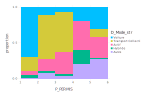

In [5]:
df = histnorm(train,0:1:8,:P_PERMIS)
plot(df, x = :P_PERMIS, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmin=1, xmax=6))

Étant donné que la variable P_Permis est séparée en 5 catégories, nous avons fait le choix évident de considérer une distribution catégorielle pour chacun des modes de transport. 

### M_dist_centre

La variable M_dist_centre décrit la distance en km du ménage au centre-ville de Montréal. L'hypothèse que nous posions quant à cette variable est que plus une personne habite proche du centre ville, moins qu'il voyagera avec sa voiture. Selon cette hypothèse, les probabilités qu'on voyage en transport en commun ou en transport actif augmente donc en fonction de la proximité au centre-ville. De plus, nous expliquerions une baisse de l'utilisation de la voiture pour les personnes y vivant pour deux raisons principales. D'une part, une majorité des personnes vivants au centre-ville y travaillent également et d'autre part, les personnes au centre-ville ont moins l'intention de prendre leur voiture en raison de la difficulté d'y voyager et de la facilité accrue de l'accès aux transports en commun et des commerces.

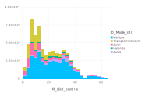

In [6]:
plot(train, x=:M_dist_centre, color=:D_Mode_str,
     Geom.histogram(bincount=30), Coord.cartesian(xmin=0, xmax = 65))

Après une première estimation et plusieurs essais et erreurs, nous avons finalement trouvé un mélange de 10 normales lorsque le mode de transport est la voiture, 7 normales lorsque le mode de transport correspond au transport collectif ou à actif, 8 normales pour l'hybride et 9 pour autre.

Voici le tracé d'un mélange de 10 normales sur la distribution de M_dist_centre lorsque la voiture est le mode de transport sélectionné.

In [7]:
plotDistribution(1, :M_dist_centre, MelangeNormales(10))

UndefVarError: UndefVarError: GMM not defined

### P_AGE

Avec cette variable, nous confirmons notre hypothèse selon laquelle les personnes plus jeunes utilisent plus le transport en commun que les personnes plus agées. Nous basons cette hypothèse sur nos expériences personnelles desquelles découle la perception que les personnes de notre génération ont plus tendance à choisir les transports en commun que la voiture lorsque possible.

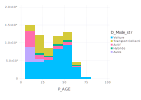

In [8]:
plot(train, x=:P_AGE, color=:D_Mode_str, Geom.histogram(bincount=8))

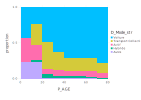

In [9]:
df = histnorm(train,0:10:80,:P_AGE)
plot(df, x = :P_AGE, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Comme nous le pensions, ce graphique démontre que les personnes non dépendantes de leurs parents pour leurs déplacements de 25 ans et moins  ont moins tendance à choisir le véhicule que les personnes de la génération d'avant.
<br><br>
La distribution la plus appropriée pour cette variable explicative est une catégorielle.

### D_HREDE

L'heure de départ (ramenée au format 24h) est une variable qui nous semble riche en informations comme nous croyons fortement qu'un déplacement dépend de l'heure à laquelle il a lieu. En effet, les déplacements aux heures de pointe pousseront peut-être une personne à choisir les transports en commun si accessibles plutôt que sa voiture alors qu'un voyage au petites heures de la nuit où les services de transport en commun sont diminués et les routes libérées du traffic encourageront un sujet à opter pour la voiture.

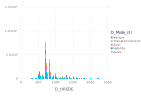

In [10]:
# modulo 2400 pour que les heures soient en format 24h
train[:D_HREDE] .%= 2400; 
plot(train, x=:D_HREDE, color=:D_Mode_str, Geom.histogram)

Comme le démontre ce graphique, il y a un étrange espacement de taille 40 récurrent. Celui-ci est dû au fait que les heures sont divisisées par 100 dans ce format alors qu'une heure contient 60 minutes. Les 40 dernières minutes ne seront donc jamais sélectionnées. De plus, les répondants à l'étude ont probablement parfois arrondit eux même l'heure de début de leurs déplacements par incertitude, rendant l'information à la minute près peu représentative. Pour palier à ces problèmes, nous avons décidé d'arrondir aux heures les plus proches.

In [11]:
# heure de départ arrondie à l'heure la plus près

function addD_HREDE_RND(file::DataFrame)
    #time of departure rounded to nearest hour
    fileSize = size(file,1)
    d = Array{Int64}(undef,fileSize)
    for i=1:fileSize
        h = file[i, :D_HREDE]
        d[i] = (h % 100) > 30 ? h + 100 - h % 100 : h - h % 100
        if d[i] == 0
            d[i] = 1
        end
    end
    file[:D_HREDE_RND] = d
end

addD_HREDE_RND(train)
addD_HREDE_RND(submissionTestData)

first(train, 5)

5×21 DataFrame. Omitted printing of 14 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

Voici le nouvel l'histogramme.

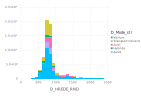

In [12]:
plot(train, x=:D_HREDE_RND, color=:D_Mode_str, Geom.histogram)

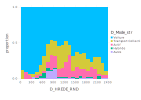

In [13]:
df = histnorm(train,0:100:2400,:D_HREDE_RND)
plot(df, x = :D_HREDE_RND, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1, xmax=2400))

Selon nous, la distribution appropriée est une catégorielle. 

### M_DOMSM

Le secteur municipal du ménage est décrit par la variable M_DOMSM. Dans un premier temps, nous avons décidé de simplement afficher l'histogramme du mode de transport en fonction des secteur municipaux.

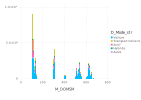

In [14]:
plot(train, x=:M_DOMSM, color=:D_Mode_str, Geom.histogram(bincount=113))

Il apparaît évident ici que l'information véhiculée par cette variable sous sa forme brute n'est pas directement utilisable et de faible valeur. Dans la section 2.2, nous créerons donc une variable M_DOMSM_G qui regroupe les secteurs par région.

### M_AUTO

Le nombre de voitures par ménage peut évidemment être une variable pertinente à notre modèle. Un ménage qui ne possède aucune voiture ne voyagera probablement pas en voiture alors qu'une persone d'un ménage avec plusieurs voitures pourrait potentiellement favoriser ce type de transport.

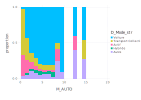

In [15]:
df = histnorm(train,0:1:19,:M_AUTO)
plot(df, x = :M_AUTO, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Comme peu de ménages possède un grand nombre de voitures (la plupart en possède une ou deux), les données sur les modes de transport de ces ménages sont moins représentatives.

De plus, nous sommes d'avis que cette variable peut suivre une distribution de poisson. Il serait possiblement intéressant d'appliquer une transformation à cette variable pour en créer une nouvelle qui définie si un ménage possède au moins une voiture ou non. Cette nouvelle variable serait une bernoulli. Toutefois, nous pensons qu'une telle transformation entraînera une perte d'information. Nous verrons dans la section du maximum de vraisemblance si le modèle est meilleur lorsqu'il utilise la première variable ou la seconde.

### M_emploiTC

Le nombre d'emplois accessible en transport en commun en moins de 45 minutes à 8h le matin est une variable que l'on pourrait certainement utiliser afin d'améliorer la prédiction de l'utilisation du transport en commun. 

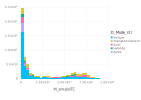

In [16]:
plot(train, x=:M_emploiTC, color=:D_Mode_str, Geom.histogram(bincount=30))

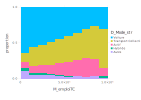

In [17]:
df = histnorm(train,0:1e5:1e6,:M_emploiTC)
plot(df, x = :M_emploiTC, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Selon ce dernier diagramme, il apparaît évident que plus il y a d'emplois accessibles en moins de 45 minutes de transport en commun à 8h le matin, plus grandes sont les chances de choisir le transport en commmun. Nous posons également une autre observation suite à l'analyse de cette figure : le mode de transport actif croît aussi en fonction du nombre d'emplois.
<br><br>De plus, nous sommes d'avis que cette variable a beaucoup plus de valeur seulement lorsque la raison du déplacement est d'aller au travail. Une combinaison de cette variable ainsi que de D_MOTIF permettrait peut-être de limiter les fausses implications que cette variable entraînerait pour les autres motifs de déplacements. Toutefois, nous sommes conscients que cette variable peut également être un indicateur de l'accessibilité générale des transports en commun et n'est pas restreinte seulement aux déplacements qui ont pour motif de se rendre au travail.

### M_dist_metro

La distance au métro est une variable intéressante qui pourrait apporter à notre modèle une précision supplémentaire. 

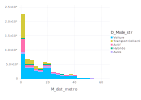

In [19]:
plot(train, x=:M_dist_metro, color=:D_Mode_str,
     Geom.histogram(bincount=20), Coord.cartesian(xmin=0, xmax = 65))

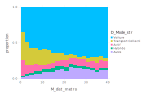

In [20]:
df = histnorm(train,0:2:40,:M_dist_metro)
plot(df, x = :M_dist_metro, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

À l'aide de plusieurs tests, nous avons finalement déterminé que la distribution la plus appropriée de chacun des modes de tranports pour cette variable correspondait à :
1. Voiture : Mélange de 7 normales
2. Transport en commun : Gamma
3. Actif : Mélange de 8 normales
4. Hybride : Gamma
5. Autre : Mélange de 10 normales.

### M_dist_train

La distance au train de banlieu a aussi le potentiel d'améliorer nos prévisions.

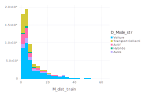

In [21]:
plot(train, x=:M_dist_train, color=:D_Mode_str,
     Geom.histogram(bincount=20), Coord.cartesian(xmin=0, xmax = 65))

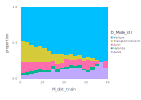

In [22]:
df = histnorm(train,0:2:40,:M_dist_train)
plot(df, x = :M_dist_train, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

À l'aide de plusieurs tests, nous avons finalement trouvé que la distribution la plus appropriée de chacun des modes de tranports pour cette variable correspondait à :
1. Voiture : Mélange de 6 normales
2. Transport en commun : Mélange de 5 normales
3. Actif : Mélange de 5 normales
4. Hybride : Mélange de 6 normales
5. Autre : Mélange de 7 normales.

## 2.2 Variables créées

Souvent, il est possible de tirer plus d'informations en combinant certaines variables pour en créer de nouvelles ou en en modifiant d'autres. Cette section regroupe les nouvelles variables créées dans le cadre de ce projet.

### M_DOMSM_G
Nous avons utilisé les résultats de cette variable avec les régions et leurs secteurs municipaux disponibles sur Moodle pour créer une nouvelle variable M_DOMSM_G qui est une catégorielle des différentes régions.

In [23]:
# Création d'une nouvelle variable M_DOMSM_G qui transforme les secteurs municipaux en une catégorielle par région

function addM_DOMSM_G(file::DataFrame)
    #group sectors by towns
    fileSize = size(file,1)
    d = Array{Int64}(undef,fileSize)
    for i=1:length(file[:M_DOMSM])
        mun = file[:M_DOMSM][i];
        if mun == 101 || mun == 102
            d[i] = 1;
        elseif (mun >= 103 && mun <= 112) || (mun >= 120 && mun <= 124)
            d[i] = 2;
        elseif mun >= 113 && mun <= 118
            d[i] = 3;
        elseif mun >= 126 && mun <= 141
            d[i] = 4;
        elseif mun >= 301 && mun <= 310
            d[i] = 5;
        elseif mun >= 401 && mun <= 408
            d[i] = 6;
        elseif mun >= 501 && mun <= 576
            d[i] = 7;
        elseif mun >= 601 && mun <= 691
            d[i] = 8;
        else
            d[i] = 9;
        end
    end
    file[:M_DOMSM_G] = d
end

addM_DOMSM_G(train)
addM_DOMSM_G(submissionTestData)

first(train, 5)

5×22 DataFrame. Omitted printing of 15 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

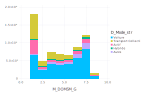

In [24]:
plot(train, x=:M_DOMSM_G, color=:D_Mode_str, Geom.histogram(bincount=9))

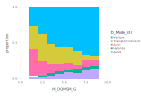

In [25]:
df = histnorm(train,0:1:9,:M_DOMSM_G)
plot(df, x = :M_DOMSM_G, y=:proportion, color=:D_Mode_str, Geom.bar, Coord.cartesian(ymin=0, ymax=1))

Ce nouveau regroupement permet de constater une augmentation de l'utilisation de la voiture pour les régions plus éloignées de Montréal. Cette variable pourrait être intéressante pour intégrer le point de départ d'un individu dans notre modèle, mais nous sommes conscient que cette variable pourrait entraîner de la colinéarité avec d'autres variables comme la distance au centre-ville, par exemple.
<br><br>
Pour la distribution, nous avons décidé d'en utiliser une catégorielle dans notre modèle, comme la transformation apportée à la variable regroupe les secteurs par région.

### M_nearest
La variable M_nearest représente la plus petite distance entre l'arret de train le plus près, le metro le plus près et le centre-ville. Les distributions obtenues semblent toutes pouvoir être très bien approximées à l'aide d'une loi Gamma

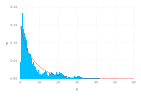

In [26]:
function addM_Nearest(file::DataFrame) 
    fileSize = size(file,1)
    #nearest between train, metro and downtown
    d = Array{Float64}(undef,fileSize)
    for i=1:fileSize
        d[i] = min(file[i,[:M_dist_train, :M_dist_metro, :M_dist_centre]]...) 
    end
    file[:M_nearest] = d
end

addM_Nearest(train)
addM_Nearest(submissionTestData)

plotDistribution(1, :M_nearest, Gamma)

### M_POSSEDE_AUTO
Une de nos hypothèse était que l'information importante de la variable M_AUTO était de savoir si un ménage possède une voiture ou non et non pas de savoir combien il en a. Ainsi, pour tester l'hypothèse, nous avons défini la variable booléenne M_POSSEDE_AUTO.

In [27]:
function addM_POSSEDE_AUTO(file::DataFrame)
    fileSize = size(file,1)
    possede_auto = [0, 1]
    e = Array{Bool}(undef,fileSize)

    ind = file[:M_AUTO] .< 1
    val = false
    e[ind] .= val

    
    ind = file[:M_AUTO] .>= 1
    val = true
    e[ind] .= val

    file[:M_Possede_Auto] = e
end

addM_POSSEDE_AUTO(train)
addM_POSSEDE_AUTO(submissionTestData)

first(train, 5)

5×24 DataFrame. Omitted printing of 17 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

Toutefois, après l'avoir testé à l'aide de la méthode du maximum de vraisemblance, il semblerait que notre hypothèse soit infirmée. En effet, les résultats d'un modèle avec la variable M_AUTO distribuée selon une loi de Poisson sont bien meilleurs que ceux d'un modèle utilisant la variable M_Possede_Auto.

### P_POSSEDE_PERMIS
Ensuite, une autre de notre hypothèses était que les catégories de la variable P_PERMIS étaient inutiles et que la seule information qui allait avoir un impact sur les résultats d'un modèle était si oui ou non la personne était détentrice d'un permis de conduire. Ainsi, nous avons apporté les modifications suivantes.

In [28]:
function addP_POSSEDE_PERMIS(file::DataFrame)
    fileSize = size(file,1)
    e = Array{Bool}(undef,fileSize)
    
    ind = file[:P_PERMIS] .== 1
    val = true
    e[ind] .= val

    ind = file[:P_PERMIS] .!= 1
    val = false
    e[ind] .= val

    file[:P_POSSEDE_PERMIS] = e
end

addP_POSSEDE_PERMIS(train)
addP_POSSEDE_PERMIS(submissionTestData)

first(train, 5)

5×25 DataFrame. Omitted printing of 18 columns
│ Row │ IPERE │ Menage  │ M_AUTO │ M_PERS │ M_DOMSM │ M_revenu │ M_dist_train │
│     │ Int64 │ Int64   │ Int64  │ Int64  │ Int64   │ Int64    │ Float64      │
├─────┼───────┼─────────┼────────┼────────┼─────────┼──────────┼──────────────┤
│ 1   │ 9     │ 1000013 │ 2      │ 3      │ 110     │ 6        │ 7.71979      │
│ 2   │ 17    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 3   │ 21    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 4   │ 31    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │
│ 5   │ 29    │ 1000014 │ 2      │ 7      │ 117     │ 2        │ 8.25894      │

Malgré nos attentes, cette nouvelle variable n'apporte pas de meilleurs résultats que l'originale. Nous expliquons cela par le fait que nous avons sous-estimé l'importance de certaines catégories de cette variable.

# 3. Préparation

Avant de pouvoir prédire à l'aide du maximum de vraisemblance ou de la classification bayésienne naïve, notre ensemble de données doit être séparé en deux ensembles : celui d'entraînement et celui de test. De plus, une fonction générique de validation avec laquelle nous évaluons le taux de réussite de prédiction est nécessaire. Le code suivant implémente une telle fonction de validation et partionne l'échantillon train en deux portions (4/5 train, 1/5 test). Cette séparation change à toutes les fois où l'algorithme est roulé.

In [29]:
k = 5

struct TestSet
    train::DataFrame
    test::DataFrame
end

function getTestSet(initialSet::DataFrame)
    n = length(initialSet[:D_Mode])
    nTest = convert(Int64, round(0.20 * n))
    index = rand(0:n-nTest+1)
    return TestSet(vcat(initialSet[1:index-1, :], initialSet[index+nTest:n, :]), initialSet[index:index+nTest-1, :])
    
    a = [1,2,3]
    b= view(a, 1:2)
    c= vcat(view(a, 1:1), view(a, 3:3))
end

function validate(estimates::Array{Int64}, realValue::Array{Int64})
    n = length(realValue)
    nEach = [0, 0, 0, 0, 0]
    right = [0, 0, 0, 0, 0]
    for i=1:n
        nEach[realValue[i]] += 1
        if estimates[i] == realValue[i]
            right[realValue[i]] += 1
        end
    end
    
    out = ""
    for i=1:k
        out *= str_mode[i] * " : " * string(right[i]/nEach[i]*100) * "%\n"
    end
    tot = sum(right)/n*100
    out *= "Total : " * string(tot) * "%\n"
    return (total=tot, output=out)
end

validate (generic function with 1 method)

# 4. Mélanges de lois Normales
Les distributions de certaines de nos variables explicative n'étaient semblable à aucune distribution de Loi de probabilité connues. Une technique que nous avons vu en classe consiste à utiliser un mélange de loi afin de représenter une distribution de forme atypique. Dans notre cas, nous avons utilisé la librairie GaussianMixtures nous permettant d'ajuster des mélanges de lois Normales par maximum de vraisemblance.

## 4.1 K-means
La fonction que nous utilisons permet d'initialiser les paramêtres des composantes à l'aide de l'algorithme K-means. Ce dernier est un algorithme de clustering qui débute en initialisant k centroïdes aléatoirement dans l'espace des données. Pour chaque itération subséquente, le centroïde minimisant une métrique de distance est associé à chaque point de donnée et les centroïdes sont repositionnés à l'emplacement moyen de tous points de données associées. L'algorithme prend fin lorsque les centroïdes convergent où lorsqu'une limite d'itération est atteinte. les paramètres utiles à la normale (moyenne, variance) peuvent ensuite être tirés de chaque ensembles.

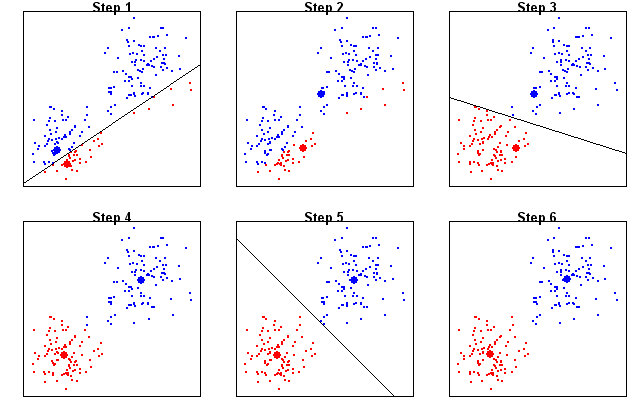

## 4.2 Algorithme EM
Après avoir initialisé les paramètres des centroïdes à une valeur relativement acceptable, l'algorithme EM est utilisé pour obtenir de meilleurs résultats. Comme vu en classe, l'algorithme EM est un algorithme itératif permettant de trouver les estimateurs du maximum de la vraisemblance à l’aide de la fonction de vraisemblance augmentée. les étapes principales sont: 

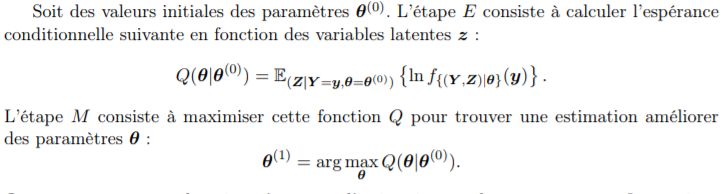

l'algorithme prend fin lorsque les paramètres convergent où lorsqu'une limite d'itération est atteinte

## 4.3 Démonstration
La création est l'ajustement du mélange de Loi est contenu à l'intérieur du constructeur GMM. Le premier paramètre représente le nombre de composantes normales du mélange, le deuxième est le vecteur de données sur lequel ajuster le mélange, le troisième spécifie d'utiliser l'algorithme k-means pour initialiser les paramètres des composantes et les deux derniers paramètres spécifient le nombre maximum d'itération pour k-means et EM respectivement

In [30]:
using GaussianMixtures

voi = train[train[:D_Mode] .== 5, :];
n = 9
IterKMeans = 100
IterEM = 20
gmm = GMM(n, voi[:M_dist_metro]; method=:kmeans, nInit=IterKMeans, nIter=IterEM)

┌ Info: Precompiling GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae]
└ @ Base loading.jl:1192
ERROR: LoadError: HDF5 not properly installed. Please run Pkg.build("HDF5")
Stacktrace:
 [1] error(::String) at ./error.jl:33
 [2] top-level scope at /Users/BenjaminBeaudry/.julia/packages/HDF5/H0XJB/src/HDF5.jl:34
 [3] include at ./boot.jl:317 [inlined]
 [4] include_relative(::Module, ::String) at ./loading.jl:1044
 [5] include(::Module, ::String) at ./sysimg.jl:29
 [6] top-level scope at none:2
 [7] eval at ./boot.jl:319 [inlined]
 [8] eval(::Expr) at ./client.jl:393
 [9] top-level scope at ./none:3
in expression starting at /Users/BenjaminBeaudry/.julia/packages/HDF5/H0XJB/src/HDF5.jl:31
ERROR: LoadError: Failed to precompile HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f] to /Users/BenjaminBeaudry/.julia/compiled/v1.0/HDF5/L7Dga.ji.
Stacktrace:
 [1] error(::String) at ./error.jl:33
 [2] compilecache(::Base.PkgId, ::String) at ./loading.jl:1203
 [3] _require(::Base.PkgId) at ./loading.j

ErrorException: Failed to precompile GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae] to /Users/BenjaminBeaudry/.julia/compiled/v1.0/GaussianMixtures/1kPVN.ji.

On peut ensuite visualiser les probabilitées et les paramètres associés à chaque composantes:

In [31]:
model = MixtureModel(gmm)
println(probs(model))
components(model)

UndefVarError: UndefVarError: gmm not defined

On peut tracer le mélange comme n'importe quelle autre distribution:

In [32]:
xx = 0:0.1:60
model = MixtureModel(gmm)
f = pdf.(model, xx)
h = layer(x = voi[:M_dist_metro], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

UndefVarError: UndefVarError: gmm not defined

# 5. Classification par maximum de vraisemblance

## 5.1 Fonctions internes (privées)

Après avoir complété l'analyse exploratoire, la première étape de prédiction employée a été celle du maximum de vraisemblance. Afin de nous faciliter la tâche, nous avons créé les fonctions suivantes. On parle ici de fonctions internes, car elles ne sont pas faites pour être appelées directement par un utilisateur. Leur usage est réservé aux fonctions publiques définies après. Dans un cadre de programmation orienté objet, ces fonctions seraient des méthodes privées de la classe du maximum de vraisemblance, alors que les publiques seraient, vous l'avez compris, publiques.

In [43]:
#Classification bayesienne naïve pour une ligne de l'ensemble de données
function determineMode(index::Int64, columns::Array{Symbol, 1}, testSet::DataFrame)
    # Y Cat(τ)
    τ = fit(Categorical, train[:D_Mode])
    # P(Y = i | X = dist) = p[i]
    p = Array{Float64}(undef, k)
    max = 1
    for i=1:k
        p[i] = logpdf(τ, i)
        for varExp in columns
           p[i] += logpdf(dist[varExp][i], testSet[varExp][index])
        end
        if p[max] < p[i]
            max = i
        end
    end
    return max
end

#Entraine le modèle avec les variables et les distributions spécifiées sur l'ensemble donné.
function getEstimation(distType::Array, columns::Array{Symbol, 1}, set::TestSet)
    # Entrainement du modèle sur les données de l'ensemble d'entrainement
    nVariablesExpl = length(columns)
    for iVarExpl in 1:nVariablesExpl
        # On entraine seulement si les paramètres ne sont pas déja connus
        if !haskey(dist, columns[iVarExpl])
            dist[columns[iVarExpl]] = Array{Distribution}(undef, k)
            fitDistributions(distType[iVarExpl,:], columns[iVarExpl], set)
        end
    end
    
    #Estimation selon les données de l'ensemble d'entrainement
    amount = length(set.test[:IPERE])
    res= Array{Int64}(undef, amount)
    for i=1:amount
       res[i] = determineMode(i, columns, set.test) 
    end
    return res
end

# Estime les les paramêtres des Loi données pour la variable $varExpl par la méthode du 
# maximum de vraisemblance (algorithme EM dans le cas d'un mélange de lois Normales)
function fitDistributions(distType::Array, varExpl::Symbol, set::TestSet)
    for mode=1:k
        trainT = set.train[set.train[:D_Mode] .== mode, :];
        if typeof(distType[mode]) == MelangeNormales
            gmm = GMM(distType[mode].n, trainT[varExpl]; method=:kmeans, nInit=100, nIter=20)
            dist[varExpl][mode] = MixtureModel(gmm)
        else
             # fit_mle retourne les estimateurs avec le maximum de la vraisemblance.
            dist[varExpl][mode] = fit_mle(distType[mode], trainT[varExpl])
        end
    end
end

fitDistributions (generic function with 1 method)

## 5.2 Fonctions publiques

La fonction getPercentRight permet d'obtenir par la méthode du maximum de vraisemblance le pourcentage de succès de notre modèle et de l'afficher à l'écran. La fonction generateSubmission génère le fichier Submission.csv a soumettre sur Kaggle en générant un modèle avec le maximum de vraisemblance aussi.

In [44]:
function getPercentRight(distType::Array, columns::Array{Symbol, 1})    
    set = getTestSet(train)
    estimation = getEstimation(distType, columns, set)
    print(validate(estimation, set.test[:D_Mode]).output)
end

function generateSubmission(distType::Array, columns::Array{Symbol, 1})
    submission = submissionTestData[:, [:IPERE]]
    set = TestSet(train, submissionTestData)
    estimation = getEstimation(distType, columns, set)
    submission = DataFrame(IPERE = submissionTestData[:IPERE],D_MODE = estimation)
    CSV.write("Submission.csv", submission)
end

generateSubmission (generic function with 1 method)

## 5.3 Exemple d'utilisation

Ici, on estime que la variable P_PERMIS est distribuée selon une loi Catégorielle. On pense la même chose pour la variable P_STATUT. Pour la variable M_dist_centre, on pense plutôt qu'elle suit une loi Gamma, alors qu'on estime la variable M_AUTO comme étant distribuée selon une loi de Poisson.

Pour les quatre variables, nous avons donné la même distribution peu importe la valeur de Y. Cependant, si nous pensions que lorsque Y = 3, la variable M_dist_centre est distribuée selon une loi normale, nous aurions pu écrire: Gamma Gamma Normal Gamma Gamma.

In [45]:
#reset global known distributions
dist = Dict()

getPercentRight([
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Gamma Gamma Gamma Gamma Gamma];
            [Poisson Poisson Poisson Poisson Poisson];
        ], [
            :P_PERMIS,
            :P_STATUT,
            :M_dist_centre,
            :M_AUTO
        ])

Voiture : 83.54221181655419%
Transport Collectif : 42.460881934566146%
Hybride : 0.0%
Actif : 27.54739336492891%
Autre : 77.76744186046511%
Total : 64.58694832138816%


## 5.4 Recherche du meilleur modèle par force brute
Faire des recherches du meilleur modèle à la main peut être fastidieux. Nous avons donc crée une fonction qui prend en paramètre une liste de variables explicatives avec leur distributions estimées et teste tous les modèles composées de combinaisons de ces variables. Comme la liste des combinaisons possibles explose lorsque le nombre de variables augmente, nous avons rajouté un paramètre qui permet de limiter la taille d'échantillon des combinaisons. Cette approche est très naïve et peut sembler peu efficace, mais elle nous permet de concentrer nos efforts sur l'analyse et la recherche plutôt que sur l'évaluation des modèles.

In [46]:
#Évalue tous les modèles faits des combinaisons de jusqu'à $maxNVars variables 
#contenues dans $columns et retourne le classement des meilleurs modèles
function getBestModel(maxNVars::Int64, distType::Array, columns::Array{Symbol, 1})    
    #créations des combinaisons
    subsetIndices = [] 
    for i in 1:maxNVars
        append!(subsetIndices, [j for j in subsets(1:length(columns), i)])
    end
    
    #entrainement et évaluation des modèles
    set = getTestSet(train)
    results = Array{NamedTuple}(undef, length(subsetIndices))
    for i in 1:length(subsetIndices)
        indices = subsetIndices[i]
        println("now testing: ", columns[indices])
        estimation = getEstimation(distType[indices, :], columns[indices], set)
        tot, out = validate(estimation, set.test[:D_Mode])
        results[i] = (total=tot, output=out, columns=columns[indices])
    end
    
    #création du classement
    sort!(results, by = x -> x.total, rev=true)
    print("Best model: ", results[1].columns, "\n", results[1].output)
    return results
end

getBestModel (generic function with 1 method)

## 5.5 Validation croisée
La validation croisée est une technique permettant d'obtenir une estimation plus précise de la précision d'un modèle, seulement a partir de l'ensemble d'entrainement. Typiquement, pour estimer la précision, nous séparions l'ensemble d'entrainement en un ensemble d'entrainement et un ensemble de validation, entrainions le modèle sur l'ensemble d'entrainement et tentions de prédire l'ensemble de validation, que nous pouvions donc vérifier avec les vraies valeurs. 

La validation croisée répète ce processus plusieurs fois en changeant la séparation de l'ensemble de données et en gardant la précision moyenne de tous les entrainements. Dans la validation croisée k-fold que nous utiliserons, k entrainements différents sont effectués en s'assurant que toutes les données apparaissent une fois dans l'ensemble de validation. Ceci fait en sorte que plus k est grand, plus l'ensemble d'entrainement sera grand à chaque fois et plus la précision des modèles sera représentative de celle du modèle entrainé sur l'ensemble complet.

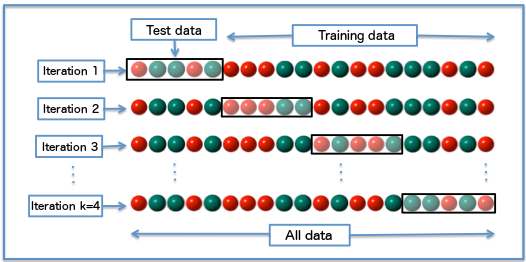

Ici, nous utiliserons la librairie MLBase pour créer les différentes séparations de l'ensemble de données pour notre validation croisée

In [47]:
using MLBase

function crossValidate(distType::Array, columns::Array{Symbol, 1}, k::Int)
    scores = Float64[]
    for (i, train_inds) in enumerate(Kfold(n, k))
        #reset global known distributions
        dist = Dict()
        
        test_inds = setdiff(1:n, train_inds)
        set = TestSet(train[train_inds, :], train[test_inds, :])
        estimation = getEstimation(distType, columns, set)
        score = validate(estimation, set.test[:D_Mode]).total
        push!(scores, score)
    end
    
    return (mean, stddev) = mean_and_std(scores)
end

ArgumentError: ArgumentError: Package MLBase not found in current path:
- Run `import Pkg; Pkg.add("MLBase")` to install the MLBase package.


## 5.6 Meilleur résultat

À l'aide de ces fonctions simples à utiliser, nous avons pu réaliser de nombreuses combinaisons de variables pour tester lesquelles permettaient d'arriver à un meilleur modèle. La combinaison avec laquelle nous avons obtenu les meilleurs résultats pour la classification par maximum de vraisemblance est la suivante.

In [38]:
 crossValidate([
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [Poisson Poisson Poisson Poisson Poisson];
        ], [
            :P_PERMIS,
            :P_AGE,
            :D_MOTIF,
            :D_HREDE,
            :M_DOMSM,
            :M_AUTO
        ], 10)

UndefVarError: UndefVarError: crossValidate not defined

# 6. Classification bayésienne naïve

Pour la classification bayésienne naïve, nous nous sommes grandement inspirés de l’exemple du filtre de spam donnée en classe. Nous avons calculé la distribution prédictive pour une variable explicative suivant une distribution catégorielle, une loi de poisson ou une loi normale. Pour les variables catégorielles, la prédiction s’obtient en calculant l’espérance de plusieurs distributions Dirichlet. Il s'agit donc de l'espérance d'une loi Beta. <br><br>
Ensuite, pour la loi de poisson, il n'y avait pas d'exemple dans les notes de cours. Nous nous sommes basé sur un document publié par University of South Carolina (http://people.stat.sc.edu/Hitchcock/stat535slidesday18.pdf). Ce document fournit les informations pour obtenir la distribution prédictive pour une variable explicative qui suit une loi de Poisson. Pour ce faire, un loi Gamma impropre de paramètre α=0 et β=0 est utilisée comme loi à priori. La distribution prédictive résultatante est une loi Binomiale Négative de paramètre r=Σxᵢ et p=1-1/(n+1). Finalement, pour les variables suivant une loi normale, on peut reconnaître pour la prédiction la forme fonctionnelle d’une normale avec des paramètres modifiés.

## 6.1 Fonctions et structures pour le calcul

### Structure qui contient les nombres d'occurences des données nécessaires

##### Occurences:
Cette structure contient les occurences des différentes variables.<br>
- mode[i] contient ni, soit le nombre de déplacements qui ont le mode de transport i
- variables[i, j][l] contient le nombre de déplacements qui ont le mode de transport i et qui ont la catégorie l pour la variable j. Ex: Si la permière variable est P_PERMIS, variables[4, 1][2] est le nombre de déplacement où la personne ne possède pas un permis de conduire et où le mode de transport est actif
- columns[j] contient les symboles associés aux colonnes qui contiennent les variables j
- nCat[j] contient le nombre de catégories pour la variable j

##### PredPoisson:
- dist[i, j] contient les loi de prédiction d'une loi de poisson obtenue à l'aide de l'inférence Bayesienne. Le i correspond au mode de déplacement et le j correspond à la variable à analyser
- columns[j] contient les symboles associés aux colonnes qui contiennent les variables j

##### PredNormal:
- dist[i, j] contient les loi de prédiction d'une loi Normale obtenue à l'aide de l'inférence Bayesienne. Le i correspond au mode de déplacement et le j correspond à la variable à analyser
- columns[j] contient les symboles associés aux colonnes qui contiennent les variables j

##### Dists:
Cette structure contient les structures des différentes lois de prédiction.<br>

In [39]:
struct Occurences
    mode::Array{Int64}
    variables::Array{Array}
    columns::Array{Symbol}
    nCat::Array{Int64}
end
struct PredPoisson
    dist::Array{NegativeBinomial}
    columns::Array{Symbol}
end
struct PredNormal
    dist::Array{Normal}
    columns::Array{Symbol}
end
struct Dists
    occ::Occurences
    predPoisson::PredPoisson
    predNormal::PredNormal
end

### Fonctions internes ("privées")

#### getOccurences(trainSet, col, nCat)
Cette fonction construit la structure Occurences pour un modèle donné.
- trainSet: l'ensemble des données d'où on va extraire les occurences. 
- col: le tableau qui contient toutes les variables dont il faut extraire les occurences.
- nCat: le nombre de catégories pour chaque variable explicative.

#### getDistributions(trainSet, colCat, nCat, colPoisson, colNormal, paramsNormal)
Cette fonction construit la structure Dists pour des modèles données.
- trainSet: l'ensemble des données d'où on va extraire les distributions
- colCat: le tableau qui contient les symboles des variables de type catégorielle.
- nCat: le nombre de catégories pour chaque variable explicative catégorielle.
- colPoisson: le tableau qui contient les symboles des variables de type Poisson.
- colNormal: le tableau qui contient les symboles des variables de type Normale.
- paramsNormal: tableau qui contient les σ² des variables de type Normale

#### findProb(occ, variable, value)
Cette fonction retourne la probabilité associée à une variable explicative pour une valeur donnée.
- occ: Contient les occurences (n) qui permettent de calculer la probabilité.
- variable: Représente l'indice de la variable pour le champ variables dans occ.
- value représente la valeur de la variable explicative.

#### filterMode(row, occ)
Cette fonction retourne quel mode est le plus probable pour un déplacement. Elle appelle la fonction findProb pour toutes les variables explicatives présentes dans occ.
- row: Le déplacement dont on veut prévoir le mode.
- occ: Contient les occurences (n) qui permettent de calculer la probabilité.

#### getEstimationBayes(set, colCat, nCat, colPoisson, colNormal, paramsNormal)
Estime pour tous les éléments de l'ensemble de test le mode
- colCat: le tableau qui contient les symboles des variables de type catégorielle.
- nCat: le nombre de catégories pour chaque variable explicative catégorielle.
- colPoisson: le tableau qui contient les symboles des variables de type Poisson.
- colNormal: le tableau qui contient les symboles des variables de type Normale.
- paramsNormal: tableau qui contient les σ² des variables de type Normale

In [ ]:
function getOccurences(trainSet::DataFrame, col::Array{Symbol}, nCat::Array{Int64})
    mode = Array{Int64, 1}(undef, k)
    for i=1:k
        mode[i] = size(trainSet[trainSet[:D_Mode] .== i, :], 1)
    end
    
    variables = Array{Array{Int64, 1}, 2}(undef, (k, length(col)))
    
    for i=1:5
        for j=1:length(col)
            variables[i, j] = Array{Int64, 1}(undef, nCat[j])
            for l=1:nCat[j]
                variables[i, j][l] = size(trainSet[(trainSet[:D_Mode] .== i) .& (trainSet[col[j]] .== l), :], 1)
            end
        end
    end
    return Occurences(mode, variables, col, nCat)
end

function getDistributions(trainSet::DataFrame, colCat::Array{Symbol}, nCat::Array{Int64}, colPoisson::Array{Symbol}, colNormal::Array{Symbol}, paramsNormal::Array{Float64, 2})
    predPoisson = Array{NegativeBinomial, 2}(undef, k, length(colPoisson))
    predNormal = Array{Normal, 2}(undef, k, length(colNormal))
    for i=1:k
        for j=1:length(colPoisson)
            data = trainSet[colPoisson[j]][trainSet[:D_Mode] .== i]
            r = sum(data)
            p = 1 - 1/(length(data) + 1)
            predPoisson[i, j] = NegativeBinomial(r, p)
        end
        for j=1:length(colNormal)
            data = trainSet[colNormal[j]][trainSet[:D_Mode] .== i]
            n = length(data)
            predNormal[i, j] = Normal(mean(data), sqrt((n + 1)/n * paramsNormal[j, i]))
        end
    end
    return Dists(getOccurences(trainSet, colCat, nCat), PredPoisson(predPoisson, colPoisson), PredNormal(predNormal, colNormal))
end

function findProb(occ::Occurences, variable::Int64, value::Int64)
    q = Array{Float64}(undef, k)
    for i=1:k
        q[i] = log(occ.variables[i, variable][value] + 1) - log(occ.mode[i] + length(occ.nCat[variable]))        
    end
    return q
end

function findProb(predPoisson::PredPoisson, variable::Int64, value::Int64)
    q = Array{Float64}(undef, k)
    for i=1:k
        q[i] = logpdf(predPoisson.dist[i, variable], value)      
    end
    return q
end

function findProb(predNormal::PredNormal, variable::Int64, value)
    q = Array{Float64}(undef, k)
    for i=1:k
        q[i] = logpdf(predNormal.dist[i, variable], value)      
    end
    return q
end

function filterMode(row::DataFrameRow, dists::Dists)
    p = Array{Float64}(undef, k)
    for i=1:k
       p[i] = log(dists.occ.mode[i] + 1) - log(sum(dists.occ.mode) + length(dists.occ.mode)) 
    end 
    for i=1:length(dists.occ.columns)
        x̃ = row[dists.occ.columns[i]]
        p = p + findProb(dists.occ, i, x̃)
    end
    for i=1:length(dists.predPoisson.columns)
        x̃ = row[dists.predPoisson.columns[i]]
        p = p + findProb(dists.predPoisson, i, x̃)
    end
    for i=1:length(dists.predNormal.columns)
        x̃ = row[dists.predNormal.columns[i]]
        p = p + findProb(dists.predNormal, i, x̃)
    end
    
     _, ind = findmax(p)
    
    return ind
end
function getEstimationBayes(set::TestSet, colCat::Array{Symbol}, nCat::Array{Int64}, colPoisson::Array{Symbol}, colNormal::Array{Symbol}, paramsNormal::Array{Float64, 2})
    dists = getDistributions(set.train, colCat, nCat, colPoisson, colNormal, paramsNormal)
    sizeTest = size(set.test, 1)
    est = Array{Int64}(undef, sizeTest)
    for i=1:sizeTest
        est[i] = filterMode(set.test[i, :], dists)
    end
    return est
end

### Fonctions "publiques"

##### getPercentRightBayes(colCat, nCat, colPoisson, colNormal, paramsNormal)
Calcule la validité d'un modèle. Appelle la fonction getEstimationBayes puis validate.

##### generateSubmissionBayes(colCat, nCat, colPoisson, colNormal, paramsNormal)
Génère un fichier de soumission avec les données envoyées. Fonctionne de la même façon que la fonction getPercentRightBayes

In [48]:
function getPercentRightBayes(colCat::Array{Symbol}, nCat::Array{Int64}, colPoisson::Array{Symbol}, colNormal::Array{Symbol}, paramsNormal::Array{Float64, 2})
    set = getTestSet(train)
    estimations = getEstimationBayes(set, colCat, nCat, colPoisson, colNormal, paramsNormal)
    print(validate(estimations, set.test[:D_Mode]).output)
end

function generateSubmissionBayes(colCat::Array{Symbol}, nCat::Array{Int64}, colPoisson::Array{Symbol}, colNormal::Array{Symbol}, paramsNormal::Array{Float64, 2})    
    submission = submissionTestData[:, [:IPERE]]
    set = TestSet(train, submissionTestData)
    estimation = getEstimationBayes(set, colCat, nCat, colPoisson, colNormal, paramsNormal)
    submission = DataFrame(IPERE = submissionTestData[:IPERE],D_MODE = estimation)
    CSV.write("Submission.csv", submission)
end

generateSubmissionBayes (generic function with 1 method)

## 6.2 Exemple d'utilisation

Comme les sections précédentes, il suffit simplement de se servir des fonctions getPercentRightBayes et generateSubmissionBayes pour créer le modèle de notre choix. Dans ce cas-ci, nous avons utilisé les variables P_PERMIS, D_MOTIF, P_STATUT, M_AUTO et M_dist_centre pour arriver à un modèle avec des résultats tout de même convaincants.

In [ ]:
getPercentRightBayes(    
    [:P_PERMIS, :D_MOTIF, :P_STATUT], # Variables catégorielles
    [5, 13, 8], # Nombre de catégories
    [:M_AUTO], # Variables poisson
    [:M_dist_centre], # Variables normales
    [[150.0 100.0 100.0 150.0 150.0];] # Variances connues
)
generateSubmissionBayes(
    [:P_PERMIS, :D_MOTIF, :P_STATUT],
    [5, 13, 8],
    [:M_AUTO],
    [:M_dist_centre],
    [[150.0 100.0 100.0 150.0 150.0];]
)

## 6.3 Recherche du meilleur modèle par force brute

Comme pour les sections 4 et 5, il aurait été très intéressant de trouver le meilleur modèle par force brute pour la classification bayésienne naïve. Toutefois, faute de temps, nos recherches se sont limitées aux cas de tests qui nous étaient familiés.

# 7. Conclusion

## 7.1 Difficultés rencontrées
Vers le milieu de la période de développement, nous nous sommes butés à une difficulté inatendue. Certains de nos meilleurs modèles avaient des précisions impressionnantes (aux alentours de 66%) lors de nos tests sur un ensemble de validation. Nos tests par validation croisée nous donnaient des résultats similaires. Cependant, lorsque venait le temps de faire une soumission,  la précision calculée par Kaggle était beaucoup moindre (autour de 59%). Ceci avait pour effet de  nous faire perdre une de nos deux soumissions possibles de la journée,  et nous ne pouvions pas accéder au résultat afin de diagnostiquer le problème. Après plusieurs tests et soumissions perdues, nous avons finalement compris notre erreur. 
<br><br>
Au début de notre pipeline, nous effectuions des modifications sur les variables  de l'ensemble de données d'entrainement. Nous rajoutions aussi des variables, mais aucune d'entre elles n'apparaissaientt dans les meilleurs modèles. Les variables n'étaient par contre pas modifiées dans l'ensemble de test! Les données utilisées pour entrainer le modèles étaient donc subtilement différentes de celles que nous utilisions pour prédire. Nous ne voyons pas cette erreur avec l'ensemble de validation, car ce dernier était pris directement de l'ensemble d'entrainement.

## 7.2 Avoir eu plus de temps
Avec plus de temps et plus de patience, nous pensons qu'il aurait été payant d'investiguer certaines pistes de solution. En voici quelques unes.
- Faire plus de combinaisons de variables et de nouvelles variables afin de tirer vraiment toute l'information des données fournies
- Ajouter la distribution gamma à notre classification bayésienne
- Faire un mélange de lois gamma
- Faire un réseau de neurones... :)